# <font color="#114b98">Catégorisez automatiquement des questions</font>

## <font color="#114b98">Notebook de test de différents modèles</font>

**Stack Overflow** est un site célèbre de questions-réponses liées au développement informatique.

L'objectif de ce projet est de développer un système de **suggestion de tags** pour ce site. Celui-ci prendra la forme d’un algorithme de machine learning qui assignera automatiquement plusieurs tags pertinents à une question.

**Livrable** : Un notebook de test de différents modèles

**Objectifs** : Comparer les modèles et générer des tags pour chacun d'entre eux

## <font color="#114b98">Sommaire</font>
[1. Chargement du jeu de données](#section_1)

[2. Approche non supervisée](#section_2)

[3. Approche supervisée](#section_3)

[4. Approche supervisée avec Word Embedding : Word2Vec](#section_4)

[5. Approche supervisée avec Word Embedding : BERT](#section_5)

[6. Approche supervisée avec Sentence Embedding : USE](#section_6)

[7. Choix du modèle pour le code final à déployer](#section_7)

## <font color="#114b98" id="section_1">1. Chargement du jeu de données</font>

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import ast
import random
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [60]:
plt.rc('axes', titlesize=22)
plt.rc('axes', labelsize=18)
titleprops = {'fontsize':20}
textprops = {'fontsize':15}
plt.style.use('ggplot')

In [61]:
main_path = 'N:/5 - WORK/1 - Projets/Projet 5/'
data = pd.read_csv(main_path+'saved_ressources/'+'data_cleaned_10000t.csv', encoding='utf8')

In [62]:
data["Texts"] = data["Texts"].apply(lambda x: ast.literal_eval(x))

In [63]:
data["Tags"] = data["Tags"].apply(lambda x: ast.literal_eval(x))

In [64]:
sample_size = 10000

In [65]:
def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    jaccard_similarity = len(intersection) / len(union)
    return jaccard_similarity

In [66]:
def get_highest_similarity_rows(data, col1, col2, n):
    data["jaccard_similarity"] = data.apply(lambda x: jaccard_similarity(x[col1], x[col2]), axis=1)
    data = data.sort_values(by="jaccard_similarity", ascending=False)
    return data.head(n)

In [67]:
data_sample = get_highest_similarity_rows(data, "Tags", "Texts", sample_size)
data_sample = data_sample[['Tags', 'Texts', 'Sentences', 'jaccard_similarity']]
data_sample.drop(['jaccard_similarity'], axis=1, inplace=True)
data_sample.reset_index(inplace=True, drop=True)

In [68]:
texts_train, texts_eval, \
tags_train, tags_eval, \
sentences_train, sentences_eval = train_test_split(
    data_sample["Texts"],
    data_sample["Tags"],
    data_sample["Sentences"],
    test_size=0.2,
    random_state=42
)

In [69]:
texts_list = texts_train.to_list()
tags_list = tags_train.to_list()
sentences = sentences_train.to_list()
flat_texts = [" ".join(text) for text in texts_list]
flat_tags = [" ".join(tag) for tag in tags_list]
vocabulary_texts = list(set([word for item in texts_list for word in item]))
vocabulary_tags = list(set([word for item in tags_list for word in item]))

In [70]:
texts_list_eval = texts_eval.to_list()
tags_list_eval = tags_eval.to_list()
sentences_list_eval = sentences_eval.to_list()
flat_texts_eval = [" ".join(text) for text in texts_list_eval]
flat_tags_eval = [" ".join(tag) for tag in tags_list_eval]
vocabulary_texts_eval = list(set([word for item in texts_list_eval for word in item]))
vocabulary_tags_eval = list(set([word for item in tags_list_eval for word in item]))

In [13]:
words = []
for text in flat_tags:
    words.extend(text.split())

counter = Counter(words)
top_500_tags = [word for word, count in counter.most_common(500)]

In [14]:
words = []
for text in flat_tags_eval:
    words.extend(text.split())

counter = Counter(words)
top_200_tags_eval = [word for word, count in counter.most_common(200)]

In [15]:
mlb = MultiLabelBinarizer(classes=top_500_tags)
tags_mlb = mlb.fit_transform(tags_list)

In [16]:
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, jaccard_score

from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Nmf
from gensim.models.ldamodel import LdaModel
from gensim.matutils import corpus2dense
from tqdm import tqdm
from sklearn.decomposition import PCA

In [17]:
n_topics = 30

In [18]:
min_df = 5

In [19]:
max_df = 0.2

In [20]:
vectorizer_CV = CountVectorizer(vocabulary=vocabulary_texts, min_df=min_df, max_df=max_df)

In [21]:
vectorizer_TFIDF = TfidfVectorizer(vocabulary=vocabulary_texts, min_df=min_df, max_df=max_df)

In [22]:
def jaccard_index(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1 & s2) / len(s1 | s2)

In [23]:
def calculate_scores(true_tags, pred_tags):
    scores = [jaccard_index(t, p) for t, p in zip(true_tags, pred_tags)]
    mean_score = sum(scores) / len(scores)
    return mean_score

In [24]:
def plot_similar_tags(true_tags, pred_tags, method):
    mean_score = calculate_scores(true_tags, pred_tags)
    similar_counts = []
    
    for pred_tags, true_tags in zip(pred_tags, true_tags):
        similar_words = set(pred_tags) & set(true_tags)
        similar_counts.append(len(similar_words))

    counter = Counter(similar_counts)
    counter = dict(sorted(counter.items()))

    # Add missing keys to counter with value 0
    keys = set(range(0, 6))
    missing_keys = keys - set(counter.keys())
    for key in missing_keys:
        counter[key] = 0
    sorted_counter = dict(sorted(counter.items()))
        
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f"Similarité des tags avec la méthode {method}", fontsize=14, fontweight='bold', y=1.05)
    axs[0].bar(sorted_counter.keys(), sorted_counter.values())
    axs[0].set_xticks(range(0,6,1))
    axs[0].set_xticklabels(sorted_counter.keys(), rotation=0)
    axs[0].set_xlabel('Nombre de tags similaires', fontsize=11)
    axs[0].set_ylabel("Nombre d'observations", fontsize=11)
    axs[0].set_title("Nombre d'observations avec un\n nombre de tags similaires", fontsize=12)   
    axs[1].pie(sorted_counter.values(), labels=sorted_counter.keys(), autopct='%1.1f%%', pctdistance=0.8)
    axs[1].legend(title='Tags\nSimilaires', bbox_to_anchor=(1, 0.9), prop={'size': 8}, title_fontsize=10)
    axs[1].set_title("Pourcentage d'observations avec \n un nombre de tags similaires", fontsize=12)
    
    textstr = ''.join((
        r'Jaccard_index = %.2f' % (mean_score, )))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    axs[1].text(0.8, 0, textstr, transform=axs[1].transAxes, fontsize=12,
                verticalalignment='top', bbox=props)
    plt.show()

In [25]:
def plot_epochs(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='lower right')
    
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper right')
    
    plt.show()

## <font color="#114b98" id="section_5">5. Approche supervisée avec Word Embedding : BERT</font>

In [26]:
import gensim
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
import multiprocessing
import transformers
from transformers import BertModel, BertTokenizer
import tensorflow
from keras.utils.vis_utils import plot_model
from keras.layers import Reshape, Flatten
import tensorflow as tf

In [27]:
print("Tensorflow Version: ", tf.__version__)
print("Num CPUs Available: ", multiprocessing.cpu_count())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

Tensorflow Version:  2.11.0
Num CPUs Available:  16
Num GPUs Available:  0
False


In [28]:
# Load a pre-trained BERT model
model = BertModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [42]:
# Preprocess the sentences
MAX_LEN = 510
sentences_ = [gensim.utils.simple_preprocess(text) for text in sentences]
sentences_ = [s[:MAX_LEN] for s in sentences_]

In [43]:
# Convert the sentences into numerical data using BERT
encoded_sentences = []
for sent in tqdm(sentences_):
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    input_ids = torch.tensor(input_ids).unsqueeze(0)
    with torch.no_grad():
        encoded_sent = model(input_ids)[0].mean(dim=1).numpy()
    encoded_sentences.append(encoded_sent)

encoded_sentences = np.array(encoded_sentences)

100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [20:34<00:00,  6.48it/s]


In [44]:
# Split the data into training and testing sets
train_sentences, test_sentences, train_tags, test_tags = train_test_split(encoded_sentences, tags_mlb, test_size=0.2, random_state=42)

In [45]:
# Define the neural network model
bert_nn_model = Sequential([
    Flatten(input_shape=(1, 768)),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(mlb.classes_), activation='sigmoid')
])

In [46]:
# Compile the model
bert_nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
bert_nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 512)               393728    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

In [48]:
# Train the model and store the history object
history = bert_nn_model.fit(train_sentences, train_tags, verbose=1, 
                            epochs=200, batch_size=32, 
                            validation_data=(test_sentences, test_tags), 
                            workers=multiprocessing.cpu_count())

Epoch 1/200
200/200 [==============================] - 2s 5ms/step - loss: 0.5287 - accuracy: 0.0237 - val_loss: 0.1348 - val_accuracy: 0.1775
Epoch 2/200
200/200 [==============================] - 1s 4ms/step - loss: 0.0786 - accuracy: 0.1747 - val_loss: 0.0399 - val_accuracy: 0.2050
Epoch 3/200
200/200 [==============================] - 1s 4ms/step - loss: 0.0437 - accuracy: 0.1995 - val_loss: 0.0368 - val_accuracy: 0.2181
Epoch 4/200
200/200 [==============================] - 1s 4ms/step - loss: 0.0400 - accuracy: 0.1983 - val_loss: 0.0360 - val_accuracy: 0.2200
Epoch 5/200
200/200 [==============================] - 1s 4ms/step - loss: 0.0385 - accuracy: 0.2145 - val_loss: 0.0356 - val_accuracy: 0.2262
Epoch 6/200
200/200 [==============================] - 1s 4ms/step - loss: 0.0378 - accuracy: 0.2072 - val_loss: 0.0354 - val_accuracy: 0.2256
Epoch 7/200
200/200 [==============================] - 1s 4ms/step - loss: 0.0373 - accuracy: 0.2217 - val_loss: 0.0348 - val_accuracy: 0.2406

Epoch 58/200
200/200 [==============================] - 1s 4ms/step - loss: 0.0274 - accuracy: 0.3597 - val_loss: 0.0271 - val_accuracy: 0.3900
Epoch 59/200
200/200 [==============================] - 1s 4ms/step - loss: 0.0273 - accuracy: 0.3625 - val_loss: 0.0269 - val_accuracy: 0.3963
Epoch 60/200
200/200 [==============================] - 1s 4ms/step - loss: 0.0272 - accuracy: 0.3648 - val_loss: 0.0270 - val_accuracy: 0.4112
Epoch 61/200
200/200 [==============================] - 1s 4ms/step - loss: 0.0271 - accuracy: 0.3689 - val_loss: 0.0271 - val_accuracy: 0.3925
Epoch 62/200
200/200 [==============================] - 1s 4ms/step - loss: 0.0272 - accuracy: 0.3555 - val_loss: 0.0272 - val_accuracy: 0.3931
Epoch 63/200
200/200 [==============================] - 1s 4ms/step - loss: 0.0272 - accuracy: 0.3636 - val_loss: 0.0270 - val_accuracy: 0.3963
Epoch 64/200
200/200 [==============================] - 1s 4ms/step - loss: 0.0272 - accuracy: 0.3566 - val_loss: 0.0271 - val_accuracy:

Epoch 115/200
200/200 [==============================] - 1s 4ms/step - loss: 0.0261 - accuracy: 0.3684 - val_loss: 0.0268 - val_accuracy: 0.4125
Epoch 116/200
200/200 [==============================] - 1s 4ms/step - loss: 0.0262 - accuracy: 0.3733 - val_loss: 0.0266 - val_accuracy: 0.4125
Epoch 117/200
200/200 [==============================] - 1s 4ms/step - loss: 0.0261 - accuracy: 0.3792 - val_loss: 0.0269 - val_accuracy: 0.4056
Epoch 118/200
200/200 [==============================] - 1s 4ms/step - loss: 0.0261 - accuracy: 0.3753 - val_loss: 0.0267 - val_accuracy: 0.4206
Epoch 119/200
200/200 [==============================] - 1s 4ms/step - loss: 0.0261 - accuracy: 0.3772 - val_loss: 0.0266 - val_accuracy: 0.4175
Epoch 120/200
200/200 [==============================] - 1s 4ms/step - loss: 0.0261 - accuracy: 0.3677 - val_loss: 0.0266 - val_accuracy: 0.4087
Epoch 121/200
200/200 [==============================] - 1s 4ms/step - loss: 0.0261 - accuracy: 0.3736 - val_loss: 0.0266 - val_ac

200/200 [==============================] - 1s 4ms/step - loss: 0.0258 - accuracy: 0.3694 - val_loss: 0.0263 - val_accuracy: 0.4119
Epoch 172/200
200/200 [==============================] - 1s 4ms/step - loss: 0.0257 - accuracy: 0.3755 - val_loss: 0.0264 - val_accuracy: 0.4263
Epoch 173/200
200/200 [==============================] - 1s 4ms/step - loss: 0.0258 - accuracy: 0.3781 - val_loss: 0.0264 - val_accuracy: 0.4125
Epoch 174/200
200/200 [==============================] - 1s 4ms/step - loss: 0.0258 - accuracy: 0.3811 - val_loss: 0.0264 - val_accuracy: 0.4150
Epoch 175/200
200/200 [==============================] - 1s 4ms/step - loss: 0.0257 - accuracy: 0.3769 - val_loss: 0.0262 - val_accuracy: 0.4131
Epoch 176/200
200/200 [==============================] - 1s 4ms/step - loss: 0.0259 - accuracy: 0.3756 - val_loss: 0.0266 - val_accuracy: 0.4081
Epoch 177/200
200/200 [==============================] - 1s 4ms/step - loss: 0.0258 - accuracy: 0.3819 - val_loss: 0.0264 - val_accuracy: 0.4137

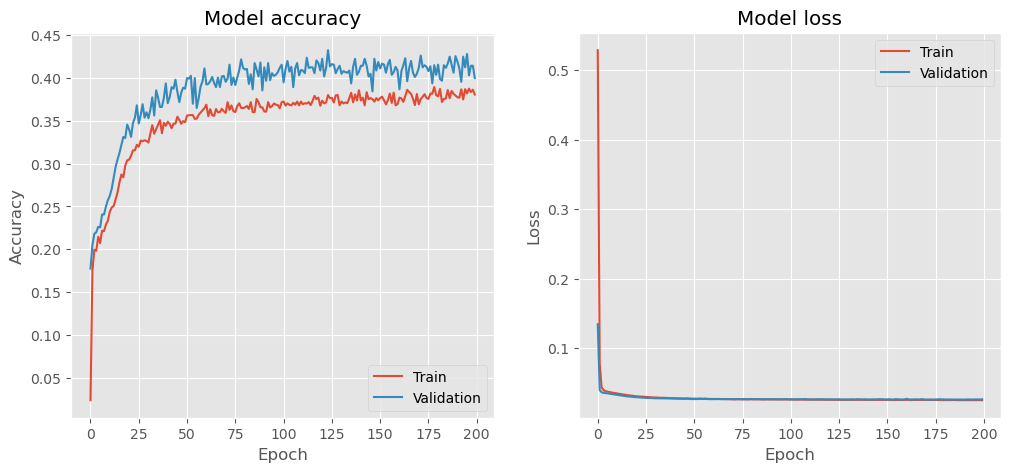

In [49]:
plot_epochs(history)

In [ ]:
dfsd+f5sdf

In [50]:
# Use the trained model to predict the tags for each sentence
pred_probs = bert_nn_model.predict(encoded_sentences)

250/250 [==============================] - 0s 947us/step


In [51]:
# Find the top 5 tags for each sentence
pred_tags = []
for sentence_probs in pred_probs:
    top_indexes = sentence_probs.argsort()[-5:][::-1]
    pred_tags.append([mlb.classes_[i] for i in top_indexes])

In [52]:
pred_tags[0:5]

[['java', 'class', 'c#', 'interface', '.net'],
 ['python', 'numpy', 'scipy', 'python-3.x', 'pandas'],
 ['wpf', 'c#', 'winforms', 'ios', 'colors'],
 ['python', 'python-3.x', 'import', 'c++', 'class'],
 ['java', 'memory', 'linux', 'jvm', 'c']]

In [54]:
tags_list[0:5]

[['c#', 'class', 'design-patterns', 'poco', 'dto'],
 ['python', 'git', 'python-2.7', 'python-3.x', 'pycharm'],
 ['flash', 'actionscript-3', 'select', 'usability', 'textfield'],
 ['javascript', 'import', 'ecmascript-6', 'wildcard', 'es6-modules'],
 ['java', 'c++', 'linux', 'ipc', 'shared-memory']]

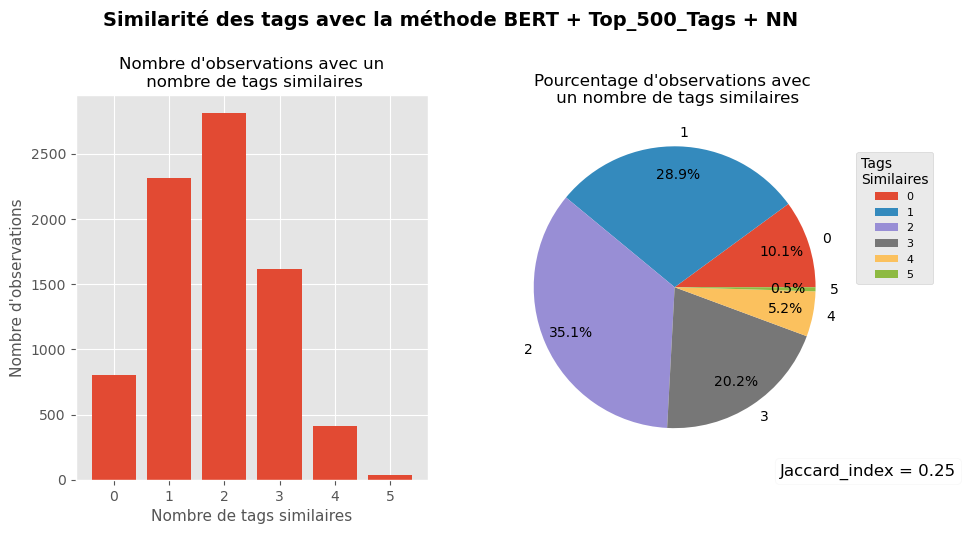

In [56]:
plot_similar_tags(tags_list, pred_tags, 'BERT + Top_500_Tags + NN')

# ON UNSEEN DATA !

In [72]:
sentences_ = [gensim.utils.simple_preprocess(text) for text in sentences_list_eval]
sentences_ = [s[:MAX_LEN] for s in sentences_]

In [76]:
# Convert the sentences into numerical data using BERT
encoded_sentences_ = []
for sent in tqdm(sentences_):
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    input_ids = torch.tensor(input_ids).unsqueeze(0)
    with torch.no_grad():
        encoded_sent = model(input_ids)[0].mean(dim=1).numpy()
    encoded_sentences_.append(encoded_sent)

encoded_sentences_ = np.array(encoded_sentences_)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [05:00<00:00,  6.66it/s]


In [77]:
pred_probs_ = bert_nn_model.predict(encoded_sentences_)

63/63 [==============================] - 0s 1ms/step


In [78]:
# Find the top 5 tags for each sentence
pred_tags_ = []
for sentence_probs in pred_probs_:
    top_indexes = sentence_probs.argsort()[-5:][::-1]
    pred_tags_.append([mlb.classes_[i] for i in top_indexes])

In [80]:
pred_tags_[0:5]

[['python', 'bash', 'shell', 'csv', 'linux'],
 ['database', 'authentication', 'security', 'ssl', 'php'],
 ['python', 'scipy', 'numpy', 'image', 'image-processing'],
 ['python', 'datetime', 'java', 'date', 'time'],
 ['list', 'python', 'linq', 'c#', 'collections']]

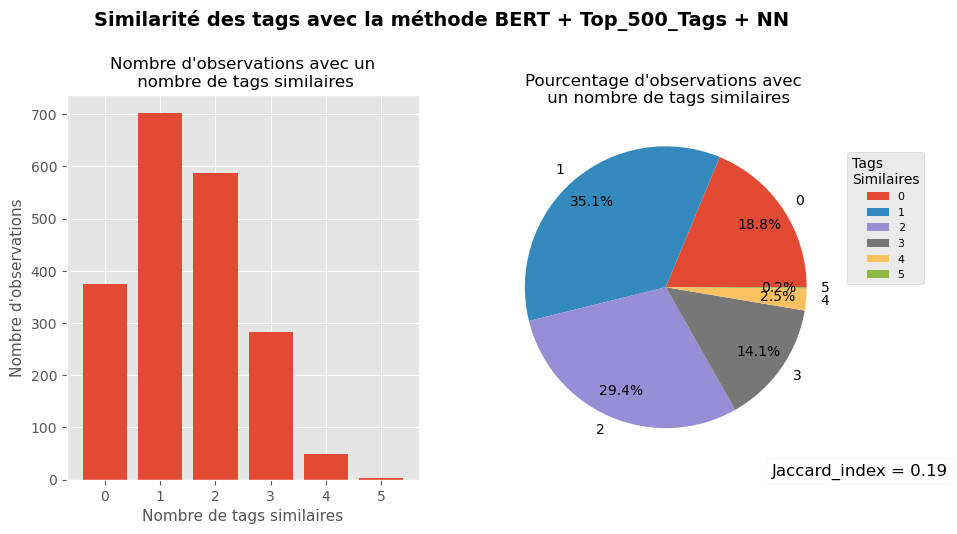

In [79]:
plot_similar_tags(tags_list_eval, pred_tags_, 'BERT + Top_500_Tags + NN')